### This notebook contains a series of exploratory data analysis techniques applied to a small Australian Real Estate DB, drawing some conclusions from feature correlations and data analysis 

In [295]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn # seaborn for data visualisations 
import warnings 
warnings.filterwarnings('ignore')
from scipy.stats import zscore 


In [296]:
### For Window's Users
import os
os.environ['PROJ_LIB'] = r'C:\Users\Owner\anaconda3\pkgs\basemap-1.2.2-py38h6201b6a_3\Library\share'

In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [298]:
df_raw=pd.read_csv(r"C:\Users\Owner\PycharmProjects\Australia_real_estate_data\aus-property-sales-sep2018-april2020.csv")
df_raw.head()

,date_sold,price,suburb,city_name,state,lat,lon,bedrooms,property_type,loc_pid,lga_pid
0,2018-09-18 00:00:00,NaN,Darling Point,Sydney,NSW,-33.869565,151.241317,3,unit,NSW1221,NSW180
1,2018-09-24 00:00:00,NaN,Darling Point,Sydney,NSW,-33.872179,151.239726,3,unit,NSW1221,NSW180
2,2018-09-26 00:00:00,1730000.0,Darling Point,Sydney,NSW,-33.868386,151.237471,2,unit,NSW1221,NSW180
3,2018-09-26 00:00:00,1928000.0,Darling Point,Sydney,NSW,-33.875465,151.236280,3,unit,NSW1221,NSW180
4,2018-10-02 00:00:00,1475000.0,Darling Point,Sydney,NSW,-33.875734,151.233575,3,unit,NSW1221,NSW180


In [299]:
# Convert date_sold to datetime format
df_raw['date_sold']=pd.to_datetime(df_raw.date_sold)

In [300]:
df_raw.info() 
df_raw.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320334 entries, 0 to 320333
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date_sold      320334 non-null  datetime64[ns]
 1   price          257826 non-null  float64       
 2   suburb         320334 non-null  object        
 3   city_name      320334 non-null  object        
 4   state          320334 non-null  object        
 5   lat            320256 non-null  float64       
 6   lon            320256 non-null  float64       
 7   bedrooms       320334 non-null  int64         
 8   property_type  320334 non-null  object        
 9   loc_pid        320334 non-null  object        
 10  lga_pid        320334 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 26.9+ MB


(320334, 11)

In [331]:
df=df_raw.copy()

# Add month and year columns
df['year']=df['date_sold'].dt.year.astype(int)
df['month']=df['date_sold'].dt.month.astype(int)

# Remove State column == city_name column and remove both lga_pid & loc_pid
df.drop(columns=['state','lga_pid','loc_pid'],inplace=True)

In [332]:
data=df.query('lat > 0')
data.lat.value_counts().sum()

1

In [333]:
data=df.query('lat < 0')
data.lat.value_counts().sum()

320255

#### Found one record of Perth of lat > 0 out of 320256 lat records, converted to negative to be similar to rest of data***

In [334]:
df.query('lat > 0')

,date_sold,price,suburb,city_name,lat,lon,bedrooms,property_type,year,month
232762,2018-09-12,NaN,Helena Valley,Perth,31.915194,116.021987,4,house,2018,9


#### Strange, we can see there one two bedroom property that is a massive outlier, let's investigate


In [335]:
df.query('price > 20000000')

,date_sold,price,suburb,city_name,lat,lon,bedrooms,property_type,year,month
296743,2019-07-17,100000000.0,Macquarie Park,Sydney,-33.777562,151.131819,2,townhouse,2019,7


In [336]:
#It's possible that the property price is accurate.. some 2bd penthouses can go for crazy 
# prices in sydney, however, for the sake of visualisation i'll be replacing this with 10mn 

df.loc[296743, 'price']=10000000

In [337]:
df.loc[232762,'lat']=-31.915194
print('Now, positive lat value is corrected.')
df.query('city_name=="Perth" & lat > 0')

Now, positive lat value is corrected.


,date_sold,price,suburb,city_name,lat,lon,bedrooms,property_type,year,month


In [338]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,257826.0,810375.016453,587353.272464,1000.000000,486000.000000,655000.00000,920000.000000,1.000000e+07
lat,320256.0,-34.630748,3.182951,-38.480451,-37.787992,-34.73801,-33.719548,-2.728698e+01
lon,320256.0,143.316299,11.109553,115.582727,144.719802,145.15884,151.070437,1.531923e+02
bedrooms,320334.0,3.108880,0.985306,0.000000,2.000000,3.00000,4.000000,5.000000e+00
year,320334.0,2019.085455,0.655433,2018.000000,2019.000000,2019.00000,2020.000000,2.020000e+03
month,320334.0,6.728761,3.510871,1.000000,3.000000,7.00000,10.000000,1.200000e+01


In [340]:
# Defining the quartile range and analysing for bedrooms feature

Q1=df.bedrooms.quantile(.25)
Q3=df.bedrooms.quantile(.75)
IQR=Q1-Q3
lower_limit=Q1-(1.5*IQR)
upper_limit=Q3+(1.5*IQR)
print("Min Value", df.bedrooms.min())
print("Max Value", df.bedrooms.max())
print("Q1", Q1)
print("Q3", Q3)
print("IQR", IQR)
print("lower_limit", lower_limit)
print("upper_limt", upper_limit)

Min Value 0
Max Value 5
Q1 2.0
Q3 4.0
IQR -2.0
lower_limit 5.0
upper_limt 1.0


In [341]:
#Here is the function which will return outliers values given column

def findoutliers(column):
    outliers=[]
    Q1=column.quantile(.25)
    Q3=column.quantile(.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limt=Q3+(1.5*IQR)
    for out1 in column:
        if out1>upper_limit or out1<lower_limit:
            outliers.append(out1)  
    return np.array(outliers)

In [342]:
# to analyse the continuous variables column to get the outlier count 
# we can print the following

print(len(findoutliers(df.bedrooms))) #no of bedroom row outliers
print(len(findoutliers(df.price)))


303278
257826


### Data visualisations

<AxesSubplot:>

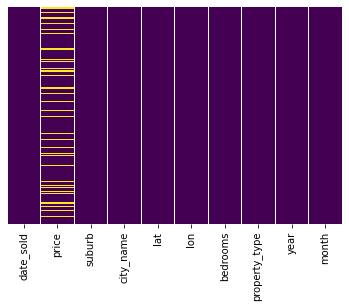

In [343]:
# Important step before modelling is to check for null values 
# Recall that earlier we replace the lon/lat values but didn't touch price

sn.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

In [344]:
# To smooth out the data set, we're going to drop the null values for price

df = df.dropna(how='any',axis=0)

<AxesSubplot:>

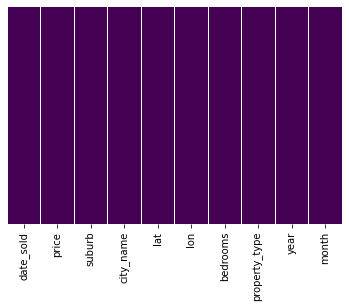

In [345]:
sn.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

In [346]:
# I also want to remove the decimals from house pricing to make for better visualisations later

df.head()

,date_sold,price,suburb,city_name,lat,lon,bedrooms,property_type,year,month
2,2018-09-26,1730000.0,Darling Point,Sydney,-33.868386,151.237471,2,unit,2018,9
3,2018-09-26,1928000.0,Darling Point,Sydney,-33.875465,151.236280,3,unit,2018,9
4,2018-10-02,1475000.0,Darling Point,Sydney,-33.875734,151.233575,3,unit,2018,10
5,2018-10-12,960000.0,Darling Point,Sydney,-33.869516,151.237239,2,unit,2018,10
7,2018-10-25,1615000.0,Darling Point,Sydney,-33.876785,151.233727,2,unit,2018,10


In [347]:
# This is to define color lists and order required for the data

# city_order depending on average price
city_order=list(pd.DataFrame(df.groupby('city_name').price.mean()).sort_values(by='price',
                                                                               ascending=False).index)

# property_order depending on average price
property_order=list(pd.DataFrame(df.groupby('property_type').price.mean()).sort_values(by='price',
                                                                               ascending=False).index)
year_order=[2018,2019,2020]

# Define city_color, property_color and year_color

city_color= sns.color_palette()[:5]
city_color.append(sns.color_palette()[9])  # To exclude brown color
city_color=255*city_color
property_color= ['saddlebrown','sandybrown','chocolate']       # Brown colors
year_color=['gainsboro','dimgrey','darkgrey']                  # Gray colors



### Box and Dist plots


In [348]:
def plotchart(col):
    fix, (ax1, ax2) = plt.subplots(1,2,figsize=(7,5))
    sn.boxplot(col, orient='v', ax=ax1)
    ax1.set_ylabel=col.name
    ax1.set_title("Box plot of {}".format(col.name))
    sn.distplot(col,ax=ax2)
    ax2.set_title("Distribution plot of {}".format(col.name))
    
def analysis_column(col):
    print('count of outlier', len(findoutliers(col)))
    print('Mean', format(col.mean()))
    print('Median', format(col.median()))
    print('Missing values', format(col.isnull().sum()))
    print('% of Missing values', format(round(100*(col.isnull().sum()/len(col)),2)))

    plotchart(col)

count of outlier 303203
Mean 3.1088289019687436
Median 3.0
Missing values 0
% of Missing values 0.0


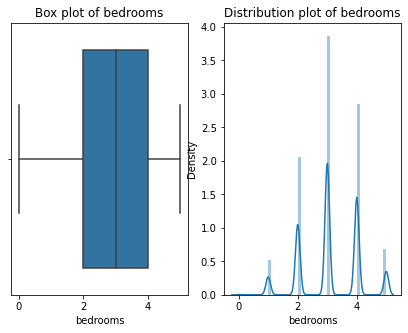

In [349]:
analysis_column(data.bedrooms)

## lon and lat distribution across cities for price with avg-price

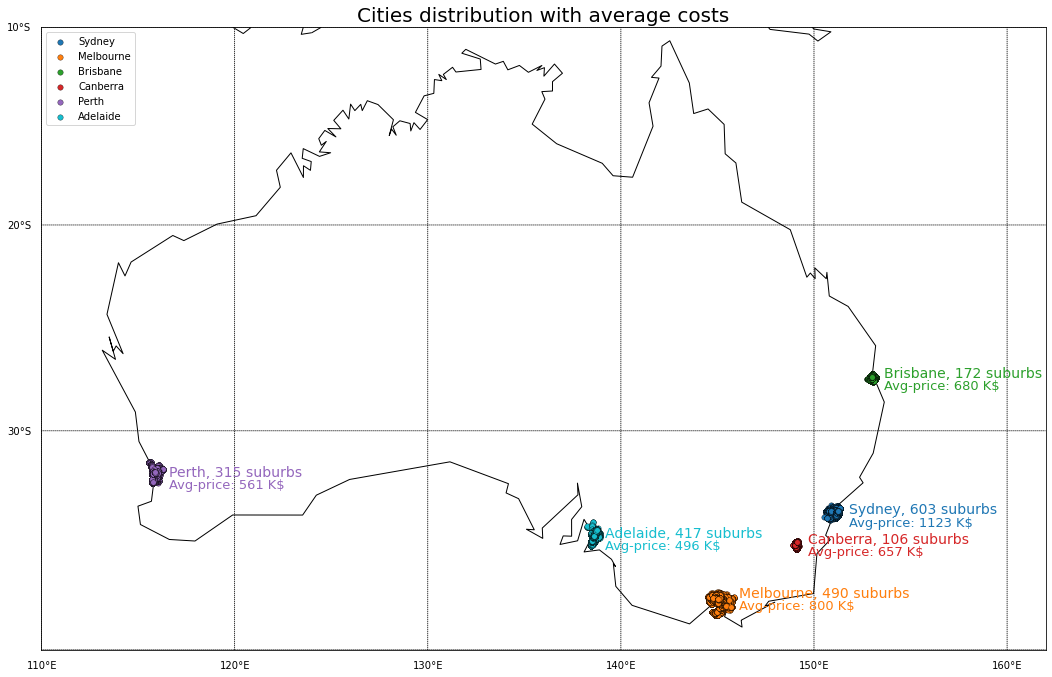

In [350]:
# (x,y) ====> (lon, lat)
fig, ax = plt.subplots(1,1,figsize=(18,12))

m = Basemap(projection='mill',
           llcrnrlat = -40,
           urcrnrlat = -10,
           llcrnrlon = 110,
           urcrnrlon = 162,
           resolution = 'c')

m.drawcoastlines()

m.drawparallels(np.arange(-90,90,10),labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1])

i=0    # used to change color
for city in city_order:
    data=df.query('city_name==@city')
    sites_lat_y = data['lat'].tolist()
    sites_lon_x = data['lon'].tolist()
    color = city_color[i]
    i+=1
    m.scatter(sites_lon_x,sites_lat_y,latlon=True,s=30, color=color, marker='o',
              alpha=1,edgecolor='k', linewidth=0.3, zorder=2, label=city )
    # To add text
    x,y = m(sites_lon_x[0],sites_lat_y[0])
    plt.text(x+65000,y,'{}, {} suburbs'.format(city,data['suburb'].nunique()),fontsize=14,color=color)
    plt.text(x+65000,y-70000,'Avg-price: {} K$'.format(int(np.round(data['price'].mean()/1000,0))),fontsize=13,color=color)

plt.title('Cities distribution with average costs', fontsize=20)
# Hide the spines
#ax.spines['left'].set_visible(False)
plt.legend();
plt.show();



# 1. Decriptive Summary for data:

In [351]:
# Most frequent data in all variables exclusive of the lonlat UID:
print ( 'Below is the most frequent data in all variables.')
df.drop(columns=['lat','lon']).mode(numeric_only=False)

Below is the most frequent data in all variables.


,date_sold,price,suburb,city_name,bedrooms,property_type,year,month
0,2019-11-30,600000.0,Pakenham,Melbourne,3,house,2019,11


### Below is the most frequent data in all variables for each city.

In [352]:
#print('Below is the most frequent data in all variables for each city.')
df.drop(columns=['lat','lon']).groupby('city_name').agg(pd.Series.mode)

,date_sold,price,suburb,bedrooms,property_type,year,month
city_name,,,,,,,
Adelaide,2018-12-14,450000.0,Morphett Vale,3,house,2019,11
Brisbane,2019-11-25,650000.0,Forest Lake,3,house,2019,11
Canberra,2019-07-01,550000.0,Kambah,3,house,2019,11
Melbourne,2019-10-26,600000.0,Pakenham,3,house,2019,10
Perth,2020-02-28,430000.0,Baldivis,4,house,2019,10
Sydney,2019-11-30,650000.0,Blacktown,3,house,2019,11


>- ***From above, For all cities the Most frequent year is 2019 and property type is house.***
>- ***There is two frequent values for months, October or November, and for bedrooms number, 3 or 4.***

## HeatMaps: One of the best ways to find the relationship between the features can be done using heat maps

We can see below in our heatmap that there is a strong correlation between price and longitute as well as # of bedrooms - which makes sense

<AxesSubplot:>

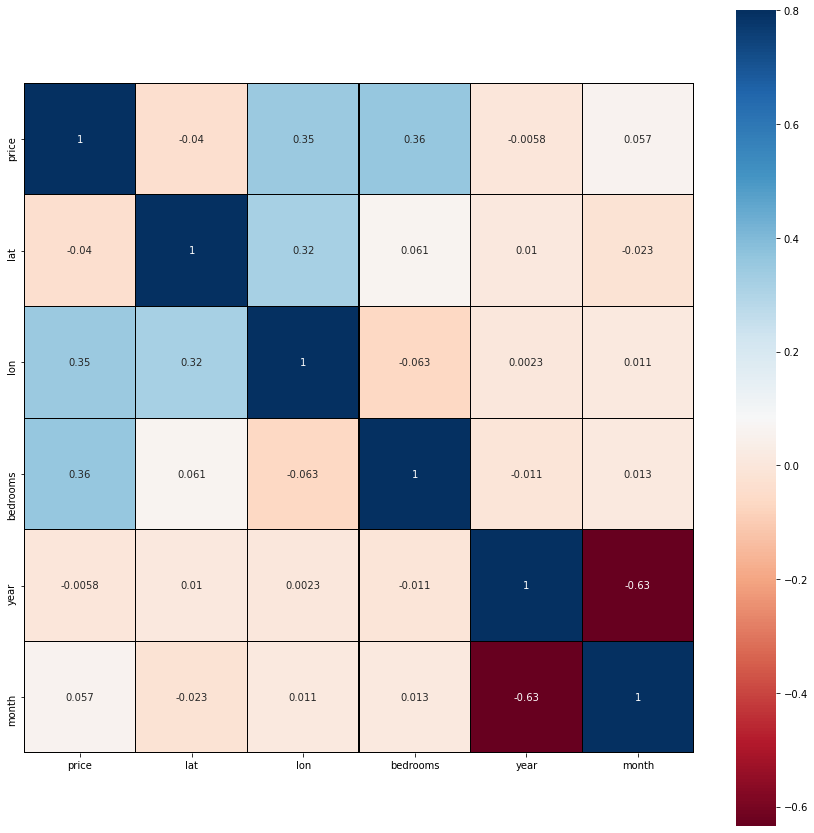

In [353]:
corr=df.corr(method='spearman')
plt.figure(figsize=(15,15))
sn.heatmap(corr, vmax= .8,linewidths=0.01, square=True, annot=True, cmap='RdBu', linecolor='black')

Let's have a look at the plot of price and bedrooms

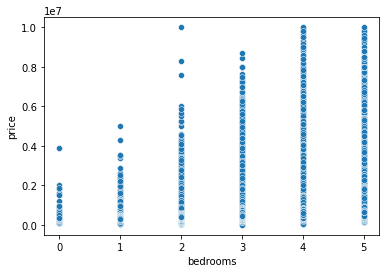

In [354]:
sns.scatterplot(x = 'bedrooms',y = 'price', data = df)

plt.show()

#### It's clear here the distribution of costly property is much more abundant as the # bedrooms increase

# 2. Exploring sold property against different variables:

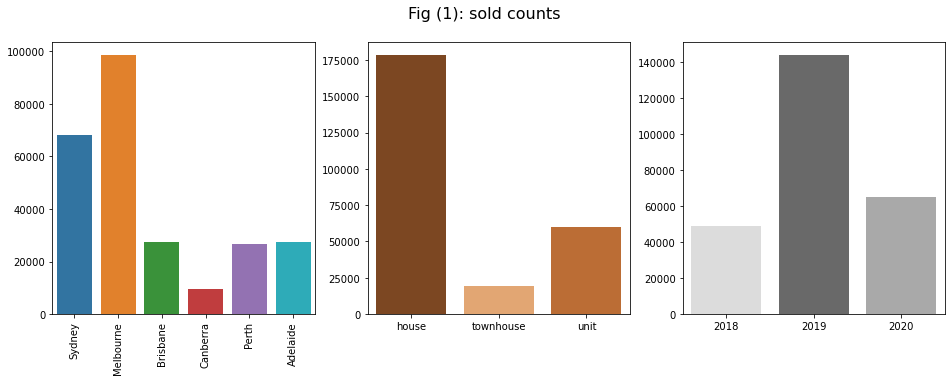

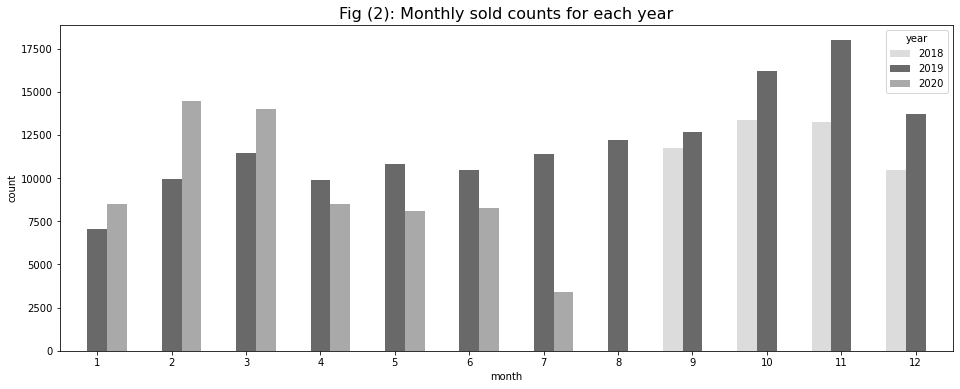

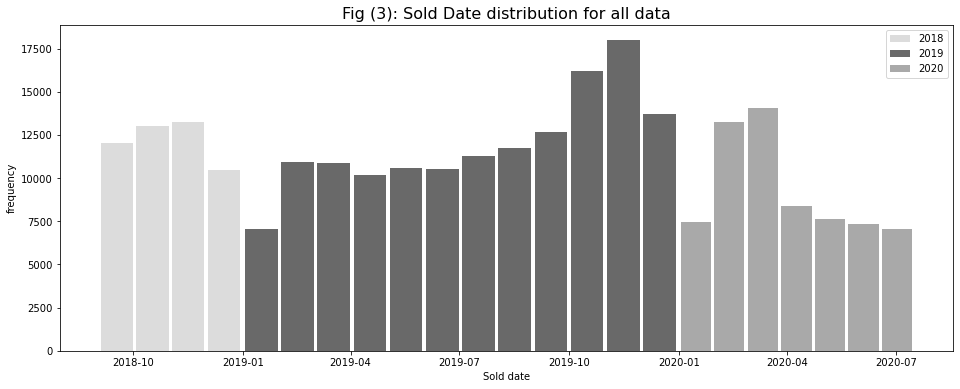

In [355]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,5))
plt.suptitle('Fig (1): sold counts',fontsize=16)
plt.subplot(ax1)
sns.countplot(data=df,x='city_name',order=city_order,palette=city_color);
plt.xticks(rotation=90);
#plt.title('Cities all time sold',fontsize=16);
plt.xlabel('')
plt.ylabel('')

plt.subplot(ax2)
sns.countplot(data=df,x='property_type',order=property_order,palette=property_color);
#plt.title('Property types all time sold',fontsize=16);
plt.xlabel('')
plt.ylabel('');

plt.subplot(ax3)
sns.countplot(data=df,x='year',order=year_order,palette=year_color);
#plt.title('Property types all time sold',fontsize=16);
plt.xlabel('')
plt.ylabel('');

plt.figure(figsize=(16,6))
sns.countplot(data=df,x='month',palette=year_color,hue='year');
plt.title('Fig (2): Monthly sold counts for each year',fontsize=16);

plt.figure(figsize=(16,6))
i=0
for year in year_order:
    #plt.scatter(data=df.query('year==@year'),x='date_sold',y='price',alpha=1/20,color=year_color[i]);
    data=df.query('year==@year')
    bins=np.arange(data.month.min(),data.month.max()+1)
    #print(len(bins))
    plt.hist(data=data,x='date_sold',color=year_color[i],bins=len(bins),rwidth=.9,label='{}'.format(year));

    i+=1
plt.title('Fig (3): Sold Date distribution for all data',fontsize=16);
plt.xlabel('Sold date')
plt.ylabel('frequency');
plt.legend();

> **Figure (1): show number of sold occuring in each city, in each property type, and in each year. We see the following:**
>- **Sydney** *is the highest in average price and the second in number of sold.*
>- **Melbourne** *is the second in average price and the highest in number of sold.*
>- Regarding property types; **houses** *represent the highest in sold counts and sold average price*, **townhouse** *is the second in average price and the least in sold counts*, and **unit** *is the second in sold counts and the least in average price.*
>- Regarding the sold year, **2019** is the highest, then **2020**, and finally **2018** in yearly graph.
>- While when we plot monthly counts for each year,found **2019** is represented by all months and that makes it the highest, then **2020**,represented by 4 months only, and **2018**, represented by 7 months only. 
> *And that makes **the yearly records unfair** *and will be excluded in the follwing analyses affected by it.*

> **Figure (2):**
>- **Year 2019** *has better perfomance than* **year 2018** *in the common months in both of them.*
>- **Year 2020** *starts with better perfomance than* **year 2019** *in the common months in both of them,
showing continue of increase of sold performance, then start to show worse performance* **after March**, *may be this due to CORONA VIRUS appearance.*

> **Figure (3):**
>- **For year 2019 distribution** ,the only year available with all months records, *we can notice from March to September, sold performance show stability, For october then November, sold performance increases, and then in December sold performance decrease again to reach it lowest performance in January.*

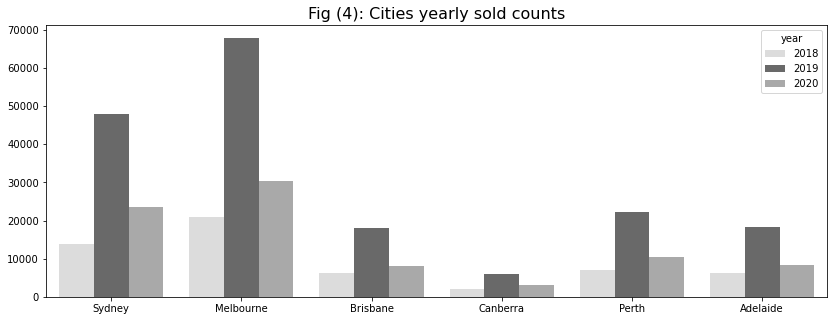

In [54]:
# Year & city_name

plt.figure(figsize=(14,5))
sns.countplot(data=df,x='city_name',order=city_order,palette=year_color,hue='year');
plt.title('Fig (4): Cities yearly sold counts',fontsize=16);
plt.xlabel('')
plt.ylabel('');

> **Figure (4): show annual number of sold occuring in each city, We see the following:**
>- **Melbourne** *is still the highest in number of sold counts followed by* **Sydney** *for each year*.

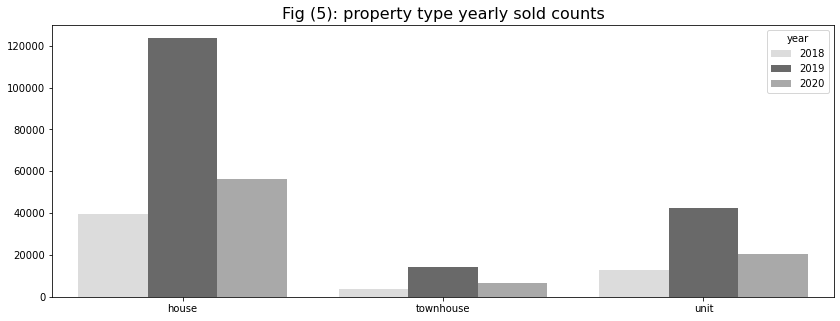

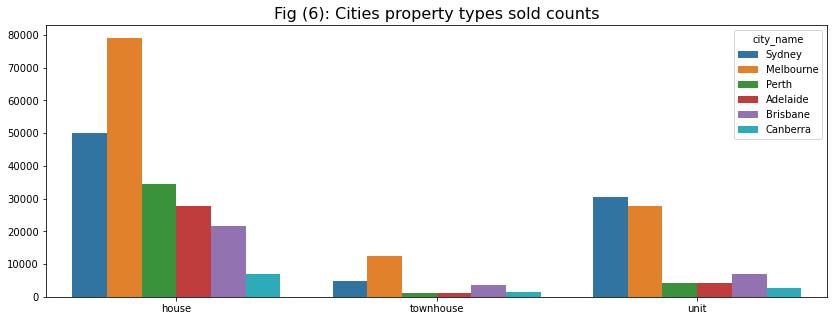

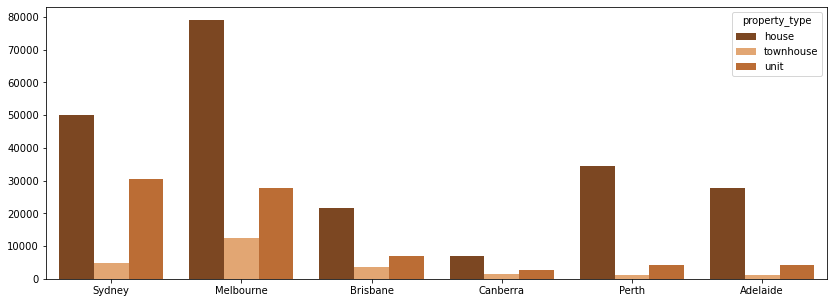

In [55]:
# Year & property_type

plt.figure(figsize=(14,5))
sns.countplot(data=df,x='property_type',order=property_order,palette=year_color,hue='year');
plt.title('Fig (5): property type yearly sold counts',fontsize=16);
plt.xlabel('')
plt.ylabel('');

# property_type & city_name

plt.figure(figsize=(14,5))
sns.countplot(data=df,x='property_type',order=property_order,palette=city_color,hue='city_name');
plt.title('Fig (6): Cities property types sold counts',fontsize=16);
plt.xlabel('')
plt.ylabel('');

plt.figure(figsize=(14,5))
sns.countplot(data=df,x='city_name',order=city_order,palette=property_color,hue='property_type',hue_order=property_order);
#plt.title('Cities yearly sold counts',fontsize=16);
plt.xlabel('')
plt.ylabel('');

> **Figure (5): show number of sold occuring in each year for each property type, We see the following:**
>- *still* **houses** *represent the highest in sold counts*, **unit** *is the second in sold counts*, and **townhouse** *is the least in sold counts.*

> **Figure (6): show number of sold occuring in each city for each property type, We see the following:**
>- **Melbourne** *is still the highest in number of sold counts follwed by* **Sydney** *for house type while for unit type* **Sydney** *take the highest sold counts with slight difference.*
>- **Sydney & Melbourne** *show highest records in unit type with big difference than other cities and records near other cities house type sold records.*



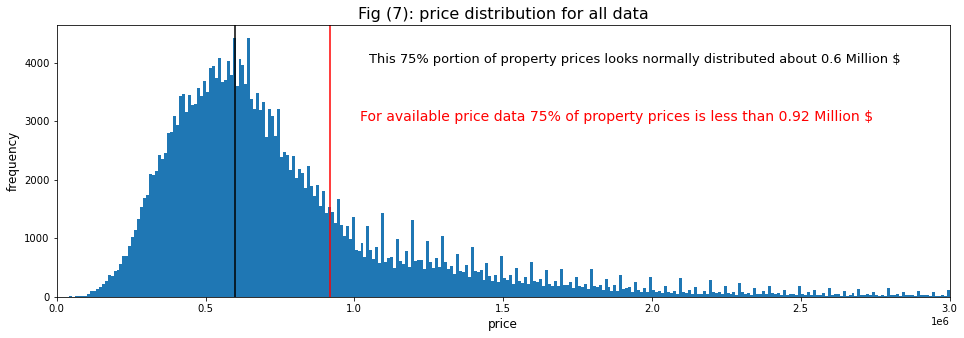

In [378]:
# price distribution

plt.figure(figsize=(16,5))
plt.hist(data=df,x='price',bins=1000);

x=np.percentile(df['price'].dropna(),75)
plt.axvline(x=x,color='red')
plt.text(x+100000,3000,
         'For available price data 75% of property prices is less than {} Million $'.format(x/1e6),fontsize=14,
        color='red',)

x=int(df['price'].dropna().mode())
plt.axvline(x=x,color='black')
plt.text(x+450000,4000,
         'This 75% portion of property prices looks normally distributed about {} Million $'.format(x/1e6),fontsize=13,
        color='black',)

plt.title('Fig (7): price distribution for all data',fontsize=16);
plt.xlim(0,3e6)
plt.xlabel('price',fontsize=12)
plt.ylabel('frequency',fontsize=12);



> **Fig (7): distribution figures for price and sold date, We see the following:**
>- **For price distribution** *,as expected, it is right skewed as very expensive properties has very little frequency. Most of prices, 75% of them are less than 0.92 Million Dollars, this 75% of prices, if separated, it looks normally distributed over 0.6 Million Dollars.*



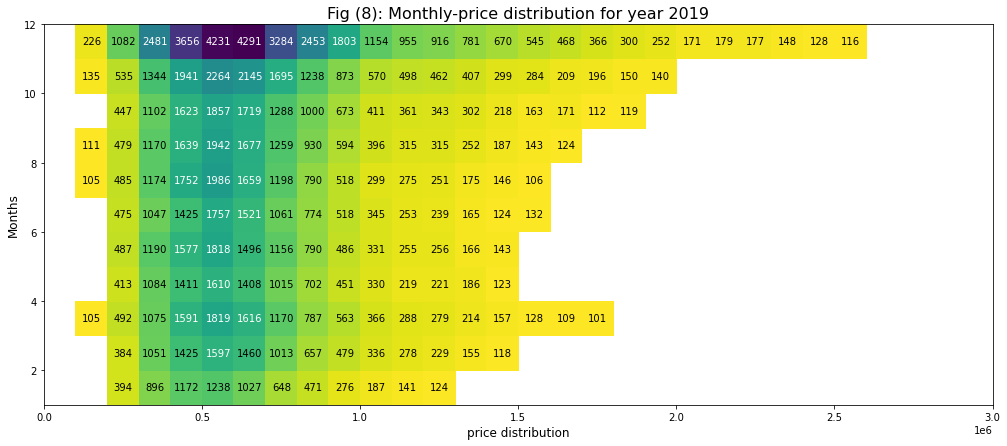

In [376]:
# price and Date distributions

plt.figure(figsize=(17,7))
data=df.dropna().query('year==2019')
bins_x=np.arange(data.price.min(),3e6,100000)
bins_y=np.arange(1,13)
h2d=plt.hist2d(data=data,x='price',y='month',cmap = 'viridis_r',cmin=100,bins=[bins_x,bins_y]);
plt.xlim(0,3e6);

plt.title('Fig (8): Monthly-price distribution for year 2019',fontsize=16)
plt.xlabel('price distribution',fontsize=12)
plt.ylabel('Months',fontsize=12);

# Annotations on each cell
counts = h2d[0]       # Using h2d =plt.hist2d (......)
# This counts has all values of each sell with the x,y corredenates
# to access these counts.


# Add text annotation on each cell
# Loop through the cell counts and add text annotations for each
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        # Add half of bin step to center the x,y of text 
        
        if c >= 1500: # increase visibility on darker cells
            plt.text(bins_x[i]+50000, bins_y[j]+0.5, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+50000, bins_y[j]+0.5, int(c),
                     ha = 'center', va = 'center', color = 'black')

> **Fig (8): distribution figures for price and sold date, We see the following:**
>- **For price distribution** *,For the same price range, sold counts are less in January and Febuary, then increase and has stable value from March to October. After October, sold counts resume increase again and nearly double its value in the end of year.*
>- **Again,** *we observe higher counts in prices around 0.5 Million Dollars in all months than prices more higher or lower than this range.*

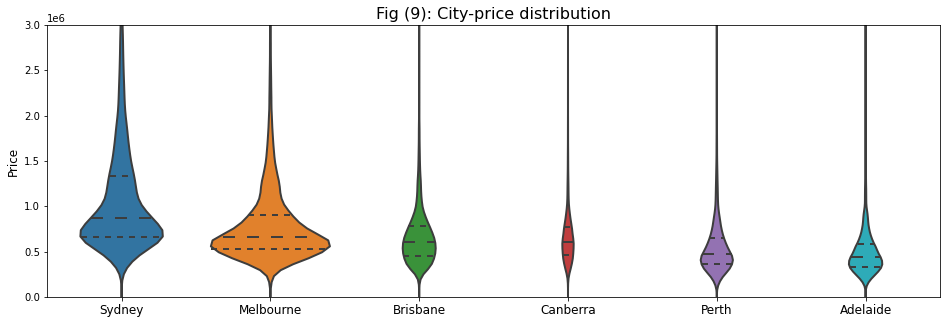

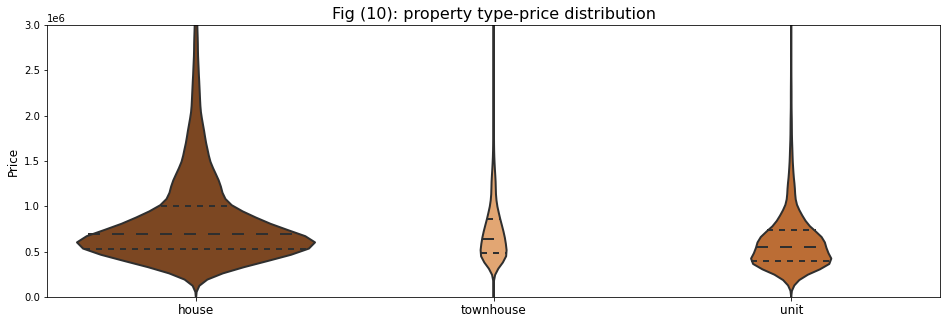

In [379]:
plt.figure(figsize=(16,5))
#sns.boxplot(data=df, y='price', x='city_name',palette=city_color,showfliers = False,order=city_order);
sns.violinplot(data=df, y='price', x='city_name',palette=city_color,showfliers = False,
           order=city_order,scale='count',gridsize=150,inner='quartiles',linewidth=2);plt.title('Fig (9): City-price distribution',fontsize=16)
plt.xlabel('',fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Price',fontsize=12);
plt.ylim(0,3e6);

plt.figure(figsize=(16,5))
sns.violinplot(data=df, y='price', x='property_type',palette=property_color,showfliers = False,
           order=property_order,scale='count',gridsize=150,inner='quartiles',linewidth=2);
plt.title('Fig (10): property type-price distribution',fontsize=16)
plt.xlabel('',fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Price',fontsize=12);
plt.ylim(0,3e6);

> **Fig (9) & Fig (10):**,dotted lines for quartiles and size for counts, **We observe the following:**
>- **Sydney,** *has half of its price data higher than most of other cities price data.* **Melbourne,** *has average prices not high like* **Sydney** *and not low like the rest of cities, that may be the reason to have higher sold counts,as shown here by size and previously plotted in Fig (4).*
>- **House,** *property has the dominating prefered property type with average prices little higher than* **townhouse and unit**.

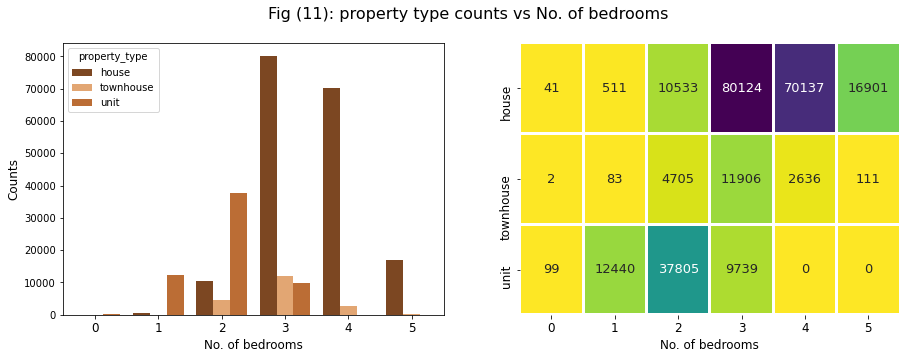

In [380]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df, hue='property_type',palette=property_color,x='bedrooms',hue_order=property_order);
plt.suptitle('Fig (11): property type counts vs No. of bedrooms',fontsize=16)
plt.xlabel('No. of bedrooms',fontsize=12)
plt.xticks(fontsize=12);
plt.ylabel('Counts',fontsize=12);

counts=df.groupby(['property_type','bedrooms']).size().reset_index(name='count')
df2=pd.DataFrame([['unit',4,0],['unit',5,0]],columns=['property_type','bedrooms','count'])
counts=counts.append(df2,ignore_index=True,)
counts=counts.pivot(index='property_type',columns='bedrooms',values='count')
plt.subplot(1,2,2)
sns.heatmap(counts,cmap = 'viridis_r',annot=True,fmt='d',linewidths=2,cbar=False,annot_kws={"size":13});
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel('',fontsize=12);
plt.xlabel('No. of bedrooms',fontsize=12);

> **Fig (11), We observe the following:**
>- **Zero bedrooms properties** *has the least counts, and* **1 or 2 bedrooms properties** *are most frequent  sold in* **unit properties**, while **3, 4 or 5 bedrooms properties** *are most frequent  sold in* **house properties**.
>- *Maximum sold units contain 2 bedrooms, while maximum sold houses contain 3 then that contain 4 bedrooms.* 

# 3. Summary of conclusion:
> **Data inclused the follwing variables 'date_sold', 'price', 'city_name', 'bedrooms',
       'property_type'] from which we get the follwing;**
>- **Regarding to sold date, The year start will the lowest sold movements that increase with time, then stabilize during March to October, then increase again and finally get abouble in sold movements at the end of the year.**

>- **Regarding to price, Most sales exist in prices around 0.5 Million Dollars, this value may be an indication of citizens average savings. While very expensive property types has the least sales, which is logically true as it is related to number of very rich people in these cities which has the low percent.**

>- **Regarding to Cities, Sydney & Melbourne are the most prefered cities in selling property. However, Sydney has higher averge price and less counts comparing with Melbourne.**

>- **Regarding to property_type & bedrooms number, Most sales are in houses with 3 & 4 rooms or units with 1 & 2 rooms. As houses are the most frequent property-type, 3 & 4 rooms are also the most frequent bedrooms number.**